In [242]:
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix
import matplotlib.pyplot as plt

In [243]:
def _euclidean_distance(X, Y, squared=False):
    XX = np.dot(X,X.T).diagonal()[:, np.newaxis]
    YY = np.dot(Y,Y.T).diagonal()[np.newaxis, :]
    distances = (-2 * np.dot(X,Y.T)) + XX + YY
    np.maximum(distances, 0, out=distances)
    if X is Y:
        np.fill_diagonal(distances, 0)
    return np.sqrt(distances, out=distances) if squared else distances

def _pairwise_kernel(X, Y = None, kernel = 'rbf', d=1):
    if Y is None:
        Y = X
    
    if kernel == 'linear':
        return np.dot(X, Y.T)
    elif kernel == 'rbf':
        dist = _euclidean_distance(X, Y, squared=True)
        # K *= -d
        return np.exp(-dist**2 / (2 * d**2))
        # return (np.exp(dist/(2*(d**2))))
    elif kernel.startswith('poly'):
        return (np.dot(X, Y.T)) ** d
    else:
        raise ValueError('Invalid kernel type.')

In [244]:


def kernel_k_means(clusters, kernel, weights, n_clusters, display=False):
  tolerance = 0.0001
  error = 0
  n = kernel.shape[0]
  center_dists = np.zeros(n)
  iter_num = 1
  
  while True:
    old_error = error
    error = 0
    
    intra_cluster = np.zeros(n_clusters)
    center_dists = np.zeros((n, n_clusters))

    for i in range(n_clusters):

      cluster_points = np.where(clusters == i)[0]
      cluster_weights = weights[cluster_points]

      intra_cluster[i] = np.dot(np.dot(kernel[cluster_points, :][:, cluster_points], 
                                       cluster_weights), cluster_weights)
      # intra_cluster[i] /= np.sum(cluster_weights) ** 2
      intra_cluster[i] /= (np.sum(cluster_weights) ** 2 + 1e-10)

      center_dists[:,i] = np.dot(kernel[:, cluster_points], cluster_weights) 
      # center_dists[:,i] = -2 * center_dists[:,i] / np.sum(cluster_weights) + intra_cluster[i]
      center_dists[:,i] = -2 * center_dists[:,i] / (np.sum(cluster_weights) + 1e-10) + intra_cluster[i]
      center_dists[:,i] += np.diag(kernel)

      center_dists[cluster_points, i] = center_dists[cluster_points, i]
      error += np.dot(cluster_weights, center_dists[cluster_points, i])
      

    min_dists, clusters = np.min(center_dists, axis=1), np.argmin(center_dists, axis=1)
    
    if display:
      print(f'Iteration {iter_num}: Error = {error}')

    # if iter_num > 1 and abs(1 - (error / old_error)) < tolerance:
    if iter_num > 1 and abs(1 - (error / (old_error + 1e-10))) < tolerance:
      break

    iter_num += 1
      
  return clusters, error, center_dists

def CWK2M(K, n_clusters, n_views, p, init_clusters, init_weights):
  if p < 1:
    raise ValueError('p must be greater than or equal to 1')

  # if np.any(init_weights < 0) or abs(np.sum(init_weights) - 1) > 1e-15:
  #   raise ValueError('Weights must be positive and sum to unity')

  n_points = K.shape[0] // n_views

  iter_num = 1
  old_error = np.inf

  clusters = init_clusters
  weights = init_weights

  trace_per_cluster_view = [[] for _ in range(n_clusters)]
  for i in range(n_views):
    K_view = K[i*n_points:(i+1)*n_points, :]  
    for j in range(n_clusters):
      cluster_points = np.where(clusters == j)[0]
      K_cluster = K_view[cluster_points[:, None], cluster_points]
      trace_per_cluster_view[j].append(np.trace(K_cluster))
  trace_per_cluster_view = np.array(trace_per_cluster_view)
  # trace_per_view = [np.trace(K[i*n_points:(i+1)*n_points, :]) for i in range(n_views)]

  while True:
    print('--------------- CWK2M Iteration {} ---------------'.format(iter_num))

    # Update clusters
    print('Updating clusters...')

    K_combined = np.zeros((n_points, n_points))
    for i in range(n_views):
      for k in range(n_clusters):
        K_combined += weights[i, k]**p * K[i*n_points:(i+1)*n_points, :]

    clusters, error, _ = kernel_k_means(clusters, K_combined, np.ones(n_points), n_clusters) 
    print('Objective after updating clusters:', error)

    if len(np.unique(clusters)) < n_clusters:
      raise ValueError('Empty clusters detected')

    # Y = csr_matrix((n_points, n_clusters))
    Y = lil_matrix((n_points, n_clusters))
    for i in range(n_clusters):
      cluster_points = np.where(clusters == i)[0]
      Y[cluster_points, i] = 1 / np.sqrt(len(cluster_points))

    trace_per_cluster_view_new = []
    for i in range(n_clusters):
      cluster_traces = []
      cluster_points = np.where(clusters == i)[0]
      Y_cluster = Y[cluster_points, i]  
      for j in range(n_views):
        K_view = K[j*n_points:(j+1)*n_points, :]
        K_cluster = K_view[cluster_points[:, None], cluster_points]
        trace_cluster = np.trace(Y_cluster.T @ K_cluster @ Y_cluster)
        cluster_traces.append(trace_cluster)
      trace_per_cluster_view_new.append(cluster_traces)
    trace_per_cluster_view_new = np.array(trace_per_cluster_view_new)
    # trace_per_view_new = [np.trace(Y.T @ K[i*n_points:(i+1)*n_points, :] @ Y) for i in range(n_views)]

    trace_diff = np.array([a - b for a, b in zip(trace_per_cluster_view, trace_per_cluster_view_new)]).T
    # trace_diff = [a - b for a, b in zip(trace_per_view, trace_per_view_new)]

    if abs(1 - (error / old_error)) < 0.0001:
      print('CWK2M reached convergence')
      break

    old_error = error

    # Update weights 
    print('Updating weights...')

    if p != 1:
      weights = 1 / np.power(trace_diff, 1/(p-1))
      weights /= np.sum(weights)
    else:
      min_idx = np.argmin(trace_diff)
      weights = np.zeros(n_views)
      weights[min_idx] = 1

    weights[weights < 1e-5] = 0 
    weights /= np.sum(weights)
    
    # print('Objective after updating weights:', (weights**p) @ trace_diff)
    print('Objective after updating weights:', np.sum((weights**p) @ trace_diff.T))
    print()

    iter_num += 1

  return clusters, weights, error

In [304]:
def global_kernel_k_means(kernel, weights, n_clusters, display=False):
  n = kernel.shape[0]
  
  best_errors = np.inf * np.ones(n_clusters)
  best_clusters = np.ones((n, n_clusters))

  # Find 1 cluster solution
  best_clusters[:,0], best_errors[0], _ = kernel_k_means(best_clusters[:,0], kernel, weights, 1, display)

  for m in range(2, n_clusters+1):

    for i in range(n):
    
      clusters = best_clusters[:,m-1].copy()
      clusters[i] = m
      
      if display:
        print(f"\nSearching for {m} clusters. Placing {m}th cluster at point {i} initially.")

      clusters, error, _ = kernel_k_means(clusters, kernel, weights, m, display)

      if display:
        print(f"Final error: {error}")

      if best_errors[m-1] > error:
        best_errors[m-1] = error
        best_clusters[:,m-1] = clusters

  if np.unique(best_clusters[:,m-1]).size < m:
    raise ValueError(f"Could not find more than {m-1} clusters")

  best_idx = np.argmin(best_errors)
  clusters = best_clusters[:, best_idx]
  error = best_errors[best_idx]

  if display:
    print(f"\nBest solution: {best_idx+1} clusters with error {error}")

  return clusters, error

In [260]:
import numpy as np


def fast_global_kernel_k_means(K, dataset_weights, total_clusters, display=False):
    # Dataset size
    data_num = K.shape[0]
    
    # Store optimal clustering error for 1,2,...,total_clusters clusters
    best_error = np.zeros(total_clusters)
    
    # Store cluster assignments for optimal 1,2,...,total_clusters clusters 
    best_clusters = np.ones((data_num, total_clusters), dtype=int)
    
    # Find 1 cluster solution
    best_clusters[:,0], best_error[0], center_dist = kernel_k_means(best_clusters[:,0], K, dataset_weights, 1, display)
    
    # Find 2,...,total_clusters solutions
    for m in range(2, total_clusters):
        max_reduction = -1
        
        # Place m-th cluster at point n, calculate guaranteed error reduction
        for n in range(data_num):
            reduction = center_dist - (K[n,n] + np.diag(K) - 2*K[n,:])
            reduction[reduction < 0] = 0
            total_reduction = np.dot(dataset_weights, reduction)

            if (total_reduction > max_reduction).all():
                max_reduction = total_reduction
                index = n
        
        # Initialize m-th cluster at point with max error reduction
        cluster_elem = best_clusters[:,m-1].copy() 
        cluster_elem[index] = m
        
        if display == 'details' or display == 'nutshell':
            print('\n\nSearching for {} clusters. Initially placing {}th cluster at point {}'.format(m, m, index))
            
        # Find m cluster solution 
        best_clusters[:,m], best_error[m], center_dist = kernel_k_means(cluster_elem, K, dataset_weights, m, display)
        center_dist = center_dist[:,m-1]
        
        if display == 'details' or display == 'nutshell':
            print('Final Clustering error={}'.format(best_error[m]))
            
        if len(np.unique(best_clusters[:,m])) < m:
            raise Exception('Not able to find more than {} clusters'.format(m-1))
            
    # Solution with lowest error is best
    min_error_idx = np.argmin(best_error)
    clustering_error = best_error[min_error_idx]
    cluster_elem = best_clusters[:, min_error_idx]
    
    if display == 'details' or display == 'nutshell':
        print('++++++++++++++++++++++++++++++++++++++++++++++++++++')
        print('Best fit: {} clusters with Clustering Error={}'.format(min_error_idx+1, clustering_error))
        print('++++++++++++++++++++++++++++++++++++++++++++++++++++')
        
    return cluster_elem, clustering_error

Global Kernel K-Means initialization
End initialization

--------------- CWK2M Iteration 1 ---------------
Updating clusters...
Objective after updating clusters: 366.9905525819627
Updating weights...
Objective after updating weights: -42.529092848575644

--------------- CWK2M Iteration 2 ---------------
Updating clusters...
Objective after updating clusters: 49.89319622001284
Updating weights...
Objective after updating weights: -42.56319742256681

--------------- CWK2M Iteration 3 ---------------
Updating clusters...
Objective after updating clusters: 49.856640276614925
Updating weights...
Objective after updating weights: -42.56319742256681

--------------- CWK2M Iteration 4 ---------------
Updating clusters...
Objective after updating clusters: 49.856640276614925
CWK2M reached convergence


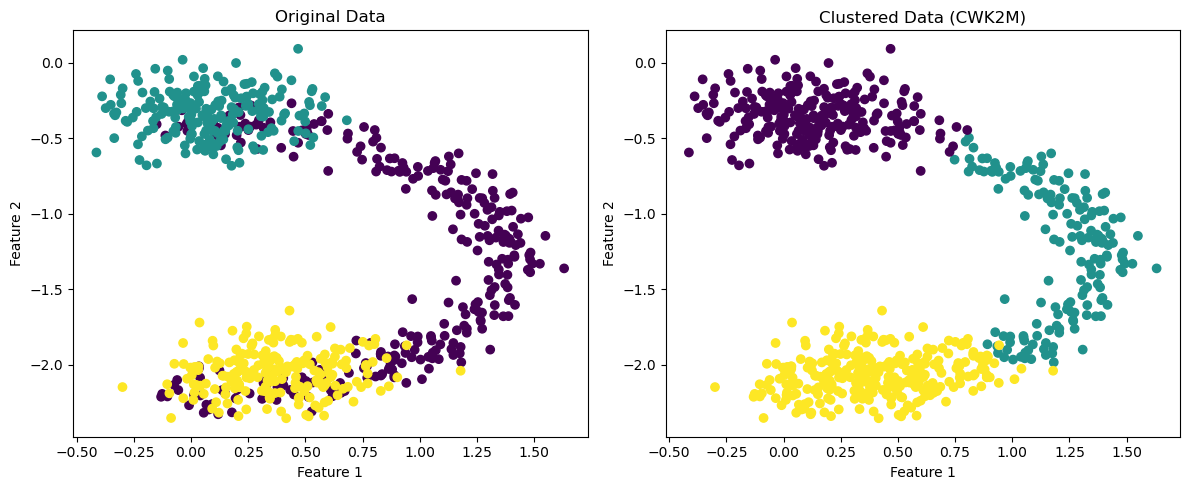

In [325]:
import numpy as np
from sklearn.datasets import make_blobs
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import rbf_kernel
import scipy.io

n_clusters = 3
data = scipy.io.loadmat('datasets/synthetic_data.mat')

X1 = data["View_1"]
X2 = data["View_2"]
X = [X1, X2]
y = data["Ground_truth"]

# K = np.array(scipy.io.loadmat('datasets/synthetic_data_kernel.mat')['K'])
K = np.vstack([_pairwise_kernel(X1, kernel="rbf", d=0.4), _pairwise_kernel(X2, kernel="rbf", d=0.4)])

# Run CWK2M
n_views = 2
p = 2
init_weights = np.full((n_views, n_clusters), 1 / n_views)
# init_weights = np.full(n_views, 1/n_views)
# print(init_weights.shape)

n_points = K.shape[0] // n_views
# Compute composite kernel 
K_combined = np.zeros((n_points, n_points))
for i in range(n_views):
  start = i * n_points
  end = (i+1) * n_points
  for k in range(n_clusters):
    K_combined += init_weights[i, k]**p * K[start:end, :]
# Initialize with Global K-Means
print('Global Kernel K-Means initialization')
init_clusters = global_kernel_k_means(K_combined, np.ones(n_points), n_clusters)
# init_clusters = np.random.randint(0, n_clusters, n_points)
print('End initialization\n')

cluster_labels, weights, error = CWK2M(K, n_clusters, n_views, p, init_clusters, init_weights)

# Plot the original data and the clustered data
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X2[:, 0], X2[:, 1], c=y, cmap='viridis')
plt.title('Original Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.subplot(1, 2, 2)
plt.scatter(X2[:, 0], X2[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Clustered Data (CWK2M)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

In [311]:
import pandas as pd

V1 = pd.read_csv('datasets/HW/mfeat-fou', header=None, delimiter="\\s+").to_numpy(dtype=np.float64)
V2 = pd.read_csv('datasets/HW/mfeat-fac', header=None, delimiter="\\s+").to_numpy(dtype=np.float64)
V3 = pd.read_csv('datasets/HW/mfeat-kar', header=None, delimiter="\\s+").to_numpy(dtype=np.float64)
V4 = pd.read_csv('datasets/HW/mfeat-pix', header=None, delimiter="\\s+").to_numpy(dtype=np.float64)

views = [V1, V2, V3, V4]
n_clusters = 10
K = np.vstack([_pairwise_kernel(v, kernel="rbf", d=0.4)/np.mean(_pairwise_kernel(v, kernel="rbf", d=0.4)) for v in views])

# Run CWK2M
n_views = len(views)
p = (10**0.7)
init_weights = np.full((n_views, n_clusters), 1 / n_views)
# init_weights = np.full(n_views, 1/n_views)

n_points = K.shape[0] // n_views
# Compute composite kernel 
K_combined = np.zeros((n_points, n_points))
for i in range(n_views):
  for k in range(n_clusters):
    start = i * n_points
    end = (i+1) * n_points
    K_combined += init_weights[i, k]**p * K[start:end, :]
# Initialize with Global K-Means
print('Global Kernel K-Means initialization')
print(K_combined.shape)
# init_clusters = global_kernel_k_means(K_combined, np.ones(n_points), n_clusters)
init_clusters = np.random.randint(0, n_clusters, n_points)
print('End initialization\n')

cluster_labels, weights, error = CWK2M(K, n_clusters, n_views, p, init_clusters, init_weights)

Global Kernel K-Means initialization
(2000, 2000)
End initialization

--------------- CWK2M Iteration 1 ---------------
Updating clusters...
Objective after updating clusters: 114170.95483492754
Updating weights...
Objective after updating weights: 6.660304435353182

--------------- CWK2M Iteration 2 ---------------
Updating clusters...
Objective after updating clusters: 0.14611510286125595
Updating weights...
Objective after updating weights: 7.735315203805479

--------------- CWK2M Iteration 3 ---------------
Updating clusters...
Objective after updating clusters: 0.14640345635849067
Updating weights...
Objective after updating weights: 7.737597390070914

--------------- CWK2M Iteration 4 ---------------
Updating clusters...
Objective after updating clusters: 0.14640473200263013
CWK2M reached convergence


In [312]:
y = np.vstack([np.full(200, i) for i in range(10)]).flatten()

In [313]:
from sklearn.metrics import normalized_mutual_info_score

# Calculate NMI
nmi_score = normalized_mutual_info_score(cluster_labels, y)

print("Normalized Mutual Information (NMI):", nmi_score)

Normalized Mutual Information (NMI): 0.6472518689623205


In [314]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(cluster_labels, y)
print(accuracy)

0.0275


In [315]:
cluster_labels

array([9, 9, 9, ..., 4, 1, 1], dtype=int64)

In [316]:
accuracy = 0
for i in range(10):
    lbls = cluster_labels[200*i:200*i+200]
    # print(np.max(np.bincount((lbls))), np.argmax(np.bincount((lbls))))
    acc = (np.max(np.bincount((lbls))) * 100/200)
    accuracy = accuracy + acc 
    print(f'{i}: {acc}%')

print(accuracy/10)

0: 97.5%
1: 38.0%
2: 70.5%
3: 71.5%
4: 68.0%
5: 88.0%
6: 36.5%
7: 72.0%
8: 93.0%
9: 40.5%
67.55
